# Homework 4 Part 2

**This is an individual assignment.**

---

Write your own code and justify all your answers. You may repurpose any functions built during lecture. You may use ```scikit-learn``` functions.

* I strongly encourage you to use the "Tensorflow-2.6.0" kernel in HiPerGator to solve this assignment.

---

In [1]:
# Import libraries and magics

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('bmh')

from sklearn.model_selection import train_test_split

---

# Exercise 1 (15 points)

**In this problem, you will be working with the [MNIST Data Set](http://yann.lecun.com/exdb/mnist/) to extract features, perform classification using the SVM algorithm and evaluate your results using metrics such as accuracy, ROC curve and confusion matrices.**

**The MNIST data set contains $28\times 28$ images of handwritten digits (class labels 0, 1, 2, 3, 4, 5, 6, 7, 8 and 9). This data set has 60,000 images for training and 10,000 images for testing. Each image is a 8-bit grayscale image and so the intensity values per pixel range from 0-255.**

**The following code cell loads the MNIST data set and displays some examples.**

In [2]:
# Loading MNIST data set
image_size = 28 # width and length
no_of_different_labels = 10 #  i.e. 0, 1, 2, 3, ..., 9
image_pixels = image_size * image_size

# Loading Training Samples
train_data = np.loadtxt("mnist_train.csv", delimiter=",")
X_train = train_data[:,1:]
t_train = train_data[:,0]

# Loading Test Samples
test_data = np.loadtxt("mnist_test.csv", delimiter=",") 
X_test = test_data[:,1:]
t_test = test_data[:,0]

X_train.shape, t_train.shape, X_test.shape, t_test.shape

((60000, 784), (60000,), (10000, 784), (10000,))

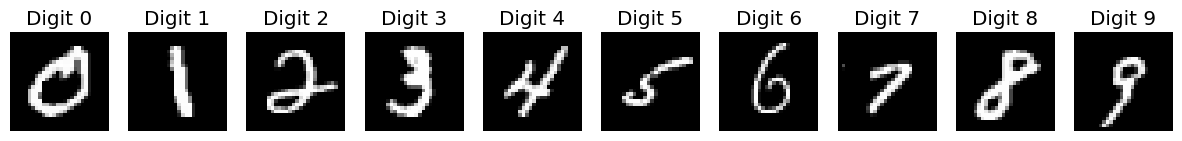

In [3]:
plt.figure(figsize=(15,5))
for i in range(10):
    plt.subplot(1,10,i+1)
    plt.imshow(X_train[np.where(t_train==i)[0][1],:].reshape((28,28)), cmap='gray')
    plt.title('Digit '+str(i)); plt.axis('off');

plt.show()

**Using this dataset, answer the following questions:**

1. **Create a PCA object using ```scikit-learn``` functions and plot the cumulative explained variance ratio. How many principal components (PCs) would you have to extract in order to preserve 90% of the explained variance in the data?**
    * **Be sure to apply any necessary preprocessing.**

Number of PCs for 90% variance: 87


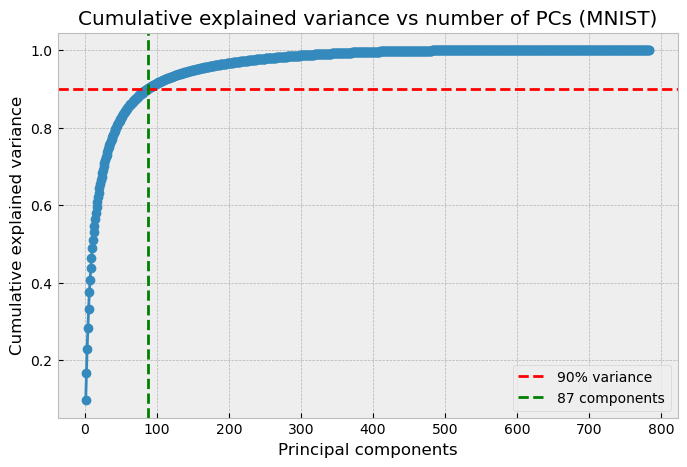

In [4]:
from sklearn.decomposition import PCA

# scale pixel intensities to [0, 1]
X_train_scaled = X_train / 255.0
X_test_scaled  = X_test  / 255.0

# fit PCA with all components (up to 784)
pca_full = PCA()
pca_full.fit(X_train_scaled)

expl_var_ratio = pca_full.explained_variance_ratio_
cum_expl_var   = np.cumsum(expl_var_ratio)

# number of PCs to reach 90% variance
threshold = 0.90
n_components_90 = np.argmax(cum_expl_var >= threshold) + 1
print("Number of PCs for 90% variance:", n_components_90)

# plot cumulative explained variance
plt.figure(figsize=(8,5))
plt.plot(np.arange(1, len(cum_expl_var)+1), cum_expl_var, marker='o')
plt.axhline(y=threshold, color='r', linestyle='--', label='90% variance')
plt.axvline(x=n_components_90, color='g', linestyle='--',
            label=f'{n_components_90} components')
plt.xlabel('Principal components')
plt.ylabel('Cumulative explained variance')
plt.title('Cumulative explained variance vs number of PCs (MNIST)')
plt.legend()
plt.grid(True)
plt.show()


From the plot produced from the code above, you'll get 87 components for 90% variance. 

2. **Plot the first 9 principal components you found in (3) with the training data. Based on this data, what is each principal component representing?**

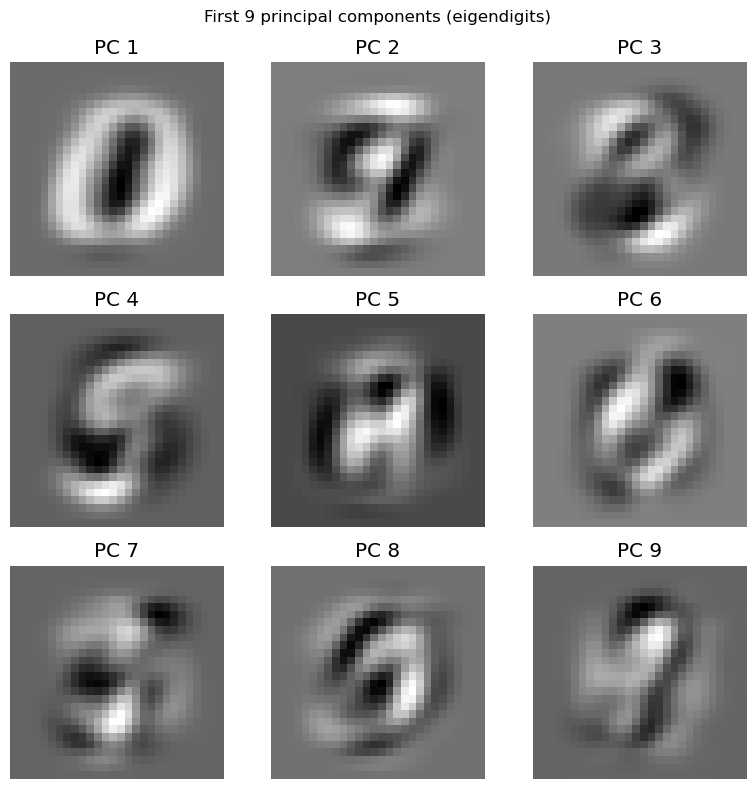

In [5]:
plt.figure(figsize=(8,8))
for i in range(9):
    pc = pca_full.components_[i].reshape(28, 28)
    plt.subplot(3, 3, i+1)
    plt.imshow(pc, cmap='gray')
    plt.title(f'PC {i+1}')
    plt.axis('off')
plt.suptitle('First 9 principal components (eigendigits)')
plt.tight_layout()
plt.show()


Based on the data, each principal component is representing the early principal components. Where these early components capture the broad structure properties: the roundness, slants, and the stroke intensity of the digits. In the later principal components they caputre the finer localized differences, like the loops, curvature, and asymmetry. 

In summary, the first prinicipal components we found do not represent the actual digits but the dominant variation within the dataset. 

3. **Reconstruct test images using the number of PCs you found in (1). Display examples.**

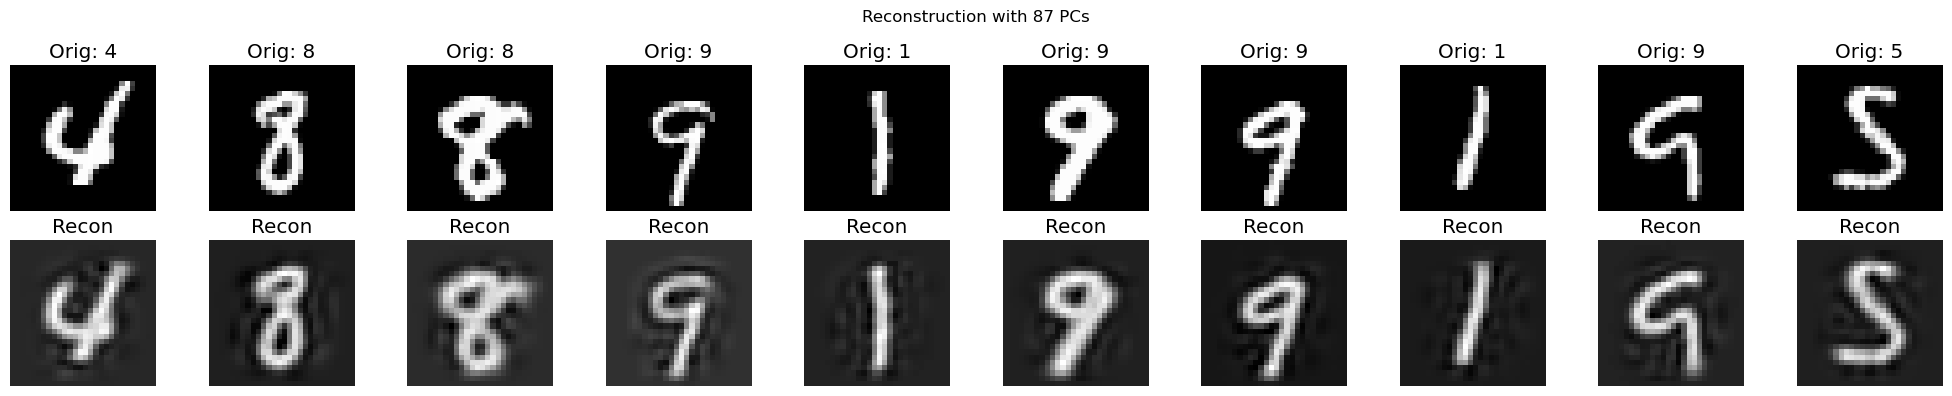

In [6]:
# fit PCA with only the chosen number of components
pca_90 = PCA(n_components=n_components_90)
pca_90.fit(X_train_scaled)

# project test set, then reconstruct
X_test_proj = pca_90.transform(X_test_scaled)
X_test_recon = pca_90.inverse_transform(X_test_proj)

# visualize some original vs reconstructed images
n_examples = 10
plt.figure(figsize=(2*n_examples, 4))

for i in range(n_examples):
    # choose any random index
    idx = np.random.randint(0, X_test_scaled.shape[0])

    # original image
    plt.subplot(2, n_examples, i+1)
    plt.imshow(X_test_scaled[idx].reshape(28, 28), cmap='gray')
    plt.title(f'Orig: {int(t_test[idx])}')
    plt.axis('off')

    # reconstructed image
    plt.subplot(2, n_examples, n_examples+i+1)
    plt.imshow(X_test_recon[idx].reshape(28, 28), cmap='gray')
    plt.title('Recon')
    plt.axis('off')

plt.suptitle(f'Reconstruction with {n_components_90} PCs')
plt.tight_layout()
plt.show()


4. **Train the following ```scikit-learn``` pipelines:**

    1. **Pipeline 1 - scales data, reduces dimensions with PCA and train an SVM with RBF kernel.**
    
    2. **Pipeline 2 - scales data, and train an SVM with RBF kernel.**

In [7]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix

n_train = 15000
X_tr = X_train[:n_train]
y_tr = t_train[:n_train]

print(f"Using {n_train} training samples for SVM")

Using 15000 training samples for SVM


A. **Pipeline 1**:

In [8]:
pipe1 = Pipeline([
    ('scaler', StandardScaler()),        # standardize each pixel feature
    ('pca', PCA(n_components=n_components_90)),
    ('svm', SVC(kernel='rbf', gamma='scale', C=1.0))
])

B. **Pipeline 2**: 

In [9]:
pipe2 = Pipeline([
    ('scaler', StandardScaler()),
    ('svm', SVC(kernel='rbf', gamma='scale', C=1.0))
])

5. **Evaluate performance in training and test sets.**

In [10]:
# TRAIN
print("Fitting Pipeline 1 (Scale + PCA + SVM)...")
pipe1.fit(X_tr, y_tr)

print("Fitting Pipeline 2 (Scale + SVM)...")
pipe2.fit(X_tr, y_tr)

# PREDICT
# (use the same X_tr for train accuracy, and full X_test for test accuracy)
y_train_pred_pipe1 = pipe1.predict(X_tr)
y_test_pred_pipe1  = pipe1.predict(X_test)

y_train_pred_pipe2 = pipe2.predict(X_tr)
y_test_pred_pipe2  = pipe2.predict(X_test)

# ACCURACIES
acc_train_pipe1 = accuracy_score(y_tr, y_train_pred_pipe1)
acc_test_pipe1  = accuracy_score(t_test, y_test_pred_pipe1)

acc_train_pipe2 = accuracy_score(y_tr, y_train_pred_pipe2)
acc_test_pipe2  = accuracy_score(t_test, y_test_pred_pipe2)

print("\nPipeline 1 (Scale + PCA + SVM):")
print(f"  Train accuracy: {acc_train_pipe1:.4f}")
print(f"  Test  accuracy: {acc_test_pipe1:.4f}")

print("\nPipeline 2 (Scale + SVM):")
print(f"  Train accuracy: {acc_train_pipe2:.4f}")
print(f"  Test  accuracy: {acc_test_pipe2:.4f}")


Fitting Pipeline 1 (Scale + PCA + SVM)...
Fitting Pipeline 2 (Scale + SVM)...

Pipeline 1 (Scale + PCA + SVM):
  Train accuracy: 0.9801
  Test  accuracy: 0.9556

Pipeline 2 (Scale + SVM):
  Train accuracy: 0.9843
  Test  accuracy: 0.9475


The two pipelines exhibit clear differences in both performance and generalization behavior. Pipeline 1, which scales the data and applies PCA before training an RBF SVM, achieves a training accuracy of 98.01% and a test accuracy of 95.56%. Although its training accuracy is slightly lower than Pipeline 2, its test accuracy is higher, indicating better generalization to unseen data. By reducing the dimensionality from 784 raw pixel features to the number of components needed to preserve 90% of the variance, PCA effectively removes noise and redundancy while retaining the most informative structure of the images. This reduced feature space helps prevent overfitting and leads to a more stable and efficient SVM classifier. In contrast, Pipeline 2 trains the SVM directly on the full 784-dimensional feature space and achieves the highest training accuracy (98.43%) but the lowest test accuracy (94.75%), showing evidence of mild overfitting. Without PCA, the SVM must model the full high-dimensional input space, making it more sensitive to noise and increasing computational cost. Overall, Pipeline 1 provides the best balance of accuracy, generalization, and efficiency, demonstrating the benefits of applying PCA before SVM classification on high-dimensional datasets like MNIST.

---

# Exercise 2 (15 points)

**In this problem, you will be working with the [California Housing dataset](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.fetch_california_housing.html). The California Housing dataset consists of 20,640 samples, each described with 8 features. Let's import it:**

In [11]:
from sklearn.datasets import fetch_california_housing 
housing = fetch_california_housing()
print(housing.DESCR)

.. _california_housing_dataset:

California Housing dataset
--------------------------

**Data Set Characteristics:**

:Number of Instances: 20640

:Number of Attributes: 8 numeric, predictive attributes and the target

:Attribute Information:
    - MedInc        median income in block group
    - HouseAge      median house age in block group
    - AveRooms      average number of rooms per household
    - AveBedrms     average number of bedrooms per household
    - Population    block group population
    - AveOccup      average number of household members
    - Latitude      block group latitude
    - Longitude     block group longitude

:Missing Attribute Values: None

This dataset was obtained from the StatLib repository.
https://www.dcc.fc.up.pt/~ltorgo/Regression/cal_housing.html

The target variable is the median house value for California districts,
expressed in hundreds of thousands of dollars ($100,000).

This dataset was derived from the 1990 U.S. census, using one row per ce

In [12]:
X = housing.data # feature matrix (attributes/features are described above)

t = housing.target # target vector (median house value expressed in $100,000)

X.shape, t.shape

((20640, 8), (20640,))

**Answer the following questions:**

1. (1 point) **Partition the data into a *full training set* and a test set. Use a 80/20 stratified split with a fixed ```random_state```. Then partition the *full training set* into a train set and a validation set. For this last partition, use a 70/30 stratified split with a fixed ```random_state```.**

In [13]:
from sklearn.model_selection import train_test_split
import numpy as np

# Bin the continuous target for stratification
num_bins = 10
bins = np.linspace(t.min(), t.max(), num_bins)
t_binned = np.digitize(t, bins)

# ---- 80/20 split (full training + test) ----
X_full_train, X_test, t_full_train, t_test = train_test_split(
    X, t,
    test_size=0.20,
    stratify=t_binned,
    random_state=42
)

# Need to bin again for the training subset
t_full_train_binned = np.digitize(t_full_train, bins)

# ---- 70/30 split (train + validation) ----
X_train, X_val, t_train, t_val = train_test_split(
    X_full_train, t_full_train,
    test_size=0.30,
    stratify=t_full_train_binned,
    random_state=42
)

X_train.shape, X_val.shape, X_test.shape


((11558, 8), (4954, 8), (4128, 8))

2. (1 point) **Apply the standardization scaling to the train, validation and test sets. Use the train set to find the mean and standard deviation.**

In [14]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(X_train)   # fit ONLY on train set

X_train_scaled = scaler.transform(X_train)
X_val_scaled   = scaler.transform(X_val)
X_test_scaled  = scaler.transform(X_test)

print("Training set means:\n", scaler.mean_)
print("\nTraining set standard deviations:\n", scaler.scale_)

Training set means:
 [ 3.87772501e+00  2.84701505e+01  5.44515439e+00  1.10030103e+00
  1.43511118e+03  3.16248778e+00  3.56482462e+01 -1.19577815e+02]

Training set standard deviations:
 [1.90447479e+00 1.26044458e+01 2.47232518e+00 5.06844756e-01
 1.17415990e+03 1.38319943e+01 2.14666536e+00 2.01249351e+00]


3. (5 points) **Use the Sequential API to build an MLP with 2 hidden layers with the Leaky ReLU activation function and associated ```alpha=0.2```. The first hidden layer should have 50 neurons and the second 10 neurons. How many neurons should you include in the input and output layers? what should be the activation function in the output layer?**

In [15]:
import tensorflow as tf
from tensorflow.keras import Sequential, Input
from tensorflow.keras.layers import Dense, LeakyReLU

model = Sequential([
    Input(shape=(8,)),            # 8 input features
    Dense(50),
    LeakyReLU(negative_slope=0.2),
    Dense(10),
    LeakyReLU(negative_slope=0.2),
    Dense(1)                      # linear activation for regression
])

The input layer requires 8 neurons because the dataset contains 8 numerical features. The output layer contains 1 neuron with a linear activation function, since this is a regression task predicting a single continuous target (median house value).

4. (3 points) **Compile the model with the Mean Squared Error [loss function](https://keras.io/api/losses/), the Adam [optimizer](https://keras.io/api/optimizers/) with learning rate of 0.001, and the ```MeanSquaredError``` [performance metric](https://keras.io/api/metrics/).**

In [16]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import MeanSquaredError as MSEMetric

model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss=MeanSquaredError(),
    metrics=[MSEMetric()]
)

5. (2 points) **Train the model using the train and validation sets with online learning, 200 epochs and early stopping callback with a patience of 10 (on the loss value for the validation set). Plot the learning curves. Discuss your observations.**


In [17]:
from tensorflow.keras.callbacks import EarlyStopping

early = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

history = model.fit(
    X_train_scaled, t_train,
    validation_data=(X_val_scaled, t_val),
    epochs=200,
    batch_size=1,
    callbacks=[early],
    verbose=1
)

Epoch 1/200
11558/11558 ━━━━━━━━━━━━━━━━━━━━ 14s 1ms/step - loss: 0.5838 - mean_squared_error: 0.5838 - val_loss: 0.4087 - val_mean_squared_error: 0.4087
Epoch 2/200
11558/11558 ━━━━━━━━━━━━━━━━━━━━ 14s 1ms/step - loss: 0.4089 - mean_squared_error: 0.4089 - val_loss: 0.3820 - val_mean_squared_error: 0.3820
Epoch 3/200
11558/11558 ━━━━━━━━━━━━━━━━━━━━ 14s 1ms/step - loss: 0.3950 - mean_squared_error: 0.3950 - val_loss: 0.3483 - val_mean_squared_error: 0.3483
Epoch 4/200
11558/11558 ━━━━━━━━━━━━━━━━━━━━ 14s 1ms/step - loss: 0.4505 - mean_squared_error: 0.4505 - val_loss: 0.3303 - val_mean_squared_error: 0.3303
Epoch 5/200
11558/11558 ━━━━━━━━━━━━━━━━━━━━ 14s 1ms/step - loss: 0.3666 - mean_squared_error: 0.3666 - val_loss: 0.3278 - val_mean_squared_error: 0.3278
Epoch 6/200
11558/11558 ━━━━━━━━━━━━━━━━━━━━ 14s 1ms/step - loss: 0.3598 - mean_squared_error: 0.3598 - val_loss: 0.3565 - val_mean_squared_error: 0.3565
Epoch 7/200
11558/11558 ━━━━━━━━━━━━━━━━━━━━ 16s 1ms/step - loss: 0.3516 - m

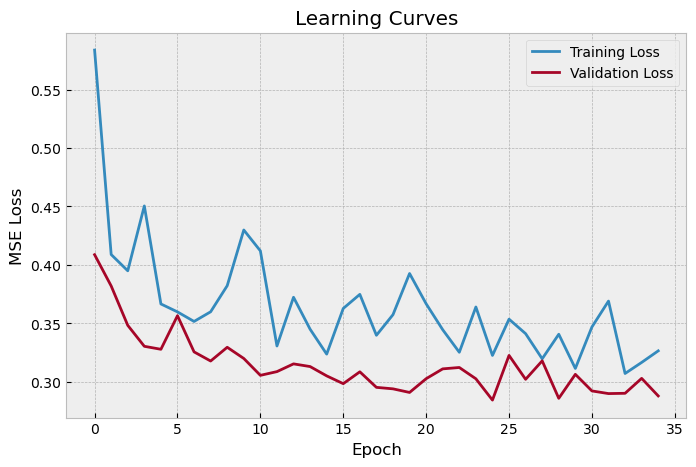

In [18]:
plt.figure(figsize=(8,5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()
plt.title('Learning Curves')
plt.grid(True)
plt.show()

The learning curves show that both training and validation loss decrease rapidly during the first several epochs, indicating that the MLP learns the main structure of the California housing data very quickly. Due to online learning (batch size = 1), the training curve is noisy, which is expected since each update is based on a single example. The validation loss is consistently lower and smoother, suggesting that the model generalizes well and is not overfitting. Early stopping terminated training at epoch 35 because the validation loss failed to improve for 10 consecutive epochs. This behavior is normal and demonstrates that the model reached its best validation performance around epochs 25-30, after which further training would not yield improvements. The overall pattern indicates good convergence and effective regularization from early stopping. 

6. (2 points) **Evaluate the mean squared error performance in the train and test sets.**

In [19]:
train_mse = model.evaluate(X_train_scaled, t_train, verbose=0)
test_mse  = model.evaluate(X_test_scaled,  t_test,  verbose=0)

print("Train MSE:", train_mse)
print("Test  MSE:", test_mse)


Train MSE: [0.3506317436695099, 0.3506317436695099]
Test  MSE: [0.3063429594039917, 0.3063429594039917]


7. (2 points) **Predict the housing prices for the train and test sets. Use these predictions to calculate the [$r^2$ score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.r2_score.html).**

In [20]:
from sklearn.metrics import r2_score

t_train_pred = model.predict(X_train_scaled)
t_test_pred  = model.predict(X_test_scaled)

r2_train = r2_score(t_train, t_train_pred)
r2_test  = r2_score(t_test,  t_test_pred)

print("Train R^2 score:", r2_train)
print("Test  R^2 score:", r2_test)


362/362 ━━━━━━━━━━━━━━━━━━━━ 0s 680us/step
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 620us/step
Train R^2 score: 0.736937614905504
Test  R^2 score: 0.769263989339799


---

# Exercise 3 (15 points)

**In this problem you will again be working with the Breast Cancer Dataset available in ```scikit-learn```.**

**This dataset contains 569 samples each described by 30 attributes. Each 30-dimensional sample is labeled as benign (label 1) or malignant (label 0). Let's import the data.**

In [21]:
from sklearn.datasets import load_breast_cancer
cancer = load_breast_cancer()

# Obtaining feature matrix and target labels
X = cancer.data
t = cancer.target

X.shape, t.shape

((569, 30), (569,))

In [22]:
X_training, X_test, t_training, t_test = train_test_split(X, t, 
                                                          test_size=0.2, 
                                                          shuffle=True, stratify=t, 
                                                          random_state=0)

X_train, X_val, t_train, t_val = train_test_split(X_training, t_training, 
                                                  test_size=0.3, 
                                                  shuffle=True, stratify=t_training, 
                                                  random_state=0)

1. (7 points) **Train an MLP with the Sequential API with 2 hidden layers: 1st hidden layer with 100 units and the relu activation function, 2nd hidden layer with 50 units with the relu activation function. Compile the model with the Adam optimization with $\eta=0.01$, track the metric accuracy, and add an early stopping callback on ```val_loss``` with 10 epochs patience.**

**Encode the input and output layers to solve this binary classification task. Choose appropriate activation function for the output layer and objective function.**

**Report the classification report in training and test sets. Discuss results.**

In [24]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(X_train)

X_train_sc = scaler.transform(X_train)
X_val_sc   = scaler.transform(X_val)
X_test_sc  = scaler.transform(X_test)


In [26]:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

# ----- build MLP -----
mlp = Sequential([
    tf.keras.Input(shape=(30,)),
    Dense(100, activation='relu'),  # input layer + hidden1
    Dense(50, activation='relu'),   # hidden2
    Dense(1, activation='sigmoid')  # output layer (probability)
])

# ----- compile -----
mlp.compile(
    optimizer=Adam(learning_rate=0.01),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# ----- early stopping -----
early_mlp = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

# ----- train -----
history_mlp = mlp.fit(
    X_train_sc, t_train,
    validation_data=(X_val_sc, t_val),
    epochs=200,
    batch_size=32,
    callbacks=[early_mlp],
    verbose=1
)

Epoch 1/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.9245 - loss: 0.1861 - val_accuracy: 0.9708 - val_loss: 0.0494
Epoch 2/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9748 - loss: 0.0776 - val_accuracy: 0.9781 - val_loss: 0.0419
Epoch 3/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9843 - loss: 0.0663 - val_accuracy: 0.9854 - val_loss: 0.0302
Epoch 4/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9843 - loss: 0.0453 - val_accuracy: 0.9635 - val_loss: 0.0728
Epoch 5/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9874 - loss: 0.0263 - val_accuracy: 0.9781 - val_loss: 0.0521
Epoch 6/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9937 - loss: 0.0173 - val_accuracy: 0.9854 - val_loss: 0.0329
Epoch 7/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 0.0079 - val_accuracy: 0.9781 - val_loss: 0.0349
Epoch 8/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 0.0045 - val_accuracy: 0.9781 - 

In [27]:
from sklearn.metrics import classification_report
import numpy as np

# probabilities → class labels (threshold 0.5)
t_train_pred_prob = mlp.predict(X_train_sc)
t_test_pred_prob  = mlp.predict(X_test_sc)

t_train_pred = (t_train_pred_prob >= 0.5).astype(int).ravel()
t_test_pred  = (t_test_pred_prob  >= 0.5).astype(int).ravel()

print("MLP – Training set:")
print(classification_report(t_train, t_train_pred, target_names=cancer.target_names))

print("\nMLP – Test set:")
print(classification_report(t_test, t_test_pred, target_names=cancer.target_names))

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
MLP – Training set:
              precision    recall  f1-score   support

   malignant       1.00      1.00      1.00       119
      benign       1.00      1.00      1.00       199

    accuracy                           1.00       318
   macro avg       1.00      1.00      1.00       318
weighted avg       1.00      1.00      1.00       318


MLP – Test set:
              precision    recall  f1-score   support

   malignant       0.93      0.93      0.93        42
      benign       0.96      0.96      0.96        72

    accuracy                           0.95       114
   macro avg       0.94      0.94      0.94       114
weighted avg       0.95      0.95      0.95       114



The MLP achieves perfect performance on the training set, with 100% precision, recall, and F1-score for both malignant and benign classes. This indicates that the network is able to fit the training data extremely well, which is expected given the relatively small size of the dataset (318 training samples after splitting) and the model’s expressive capacity (two hidden layers with 100 and 50 neurons). Early stopping helps prevent excessive overfitting, but perfect training metrics still suggest that the model has enough flexibility to fully memorize the training examples.

On the test set, the MLP achieves an accuracy of 95%, with class-specific F1-scores of 0.93 for malignant and 0.96 for benign. The high performance on unseen data indicates that the model generalizes well despite its ability to perfectly fit the training set. The slightly lower recall for the malignant class (0.93) means that a small number of malignant tumors were misclassified as benign. In medical contexts, this type of error is more critical because false negatives (missing a malignant tumor) carry higher risk. Nonetheless, the recall and precision values remain strong for both classes.

The small gap between training accuracy (100%) and test accuracy (95%) indicates mild overfitting, which is normal for neural networks trained on small datasets. However, the model’s strong test-set metrics and balanced precision/recall demonstrate that early stopping and proper regularization helped maintain excellent generalization. Overall, the MLP performs very effectively on this classification task, with only a small decrease in performance on unseen data.

2. (8 points) **Train a CNN with the Sequential API with the following architecture:**

* **convolutional layer with with 8 $3\times 1$ filters, zeros-padding and the relu activation function**
* **max-pooling layer with a pool size of 2 and a stride of 2**
* **convolutional layer with 16 $7\times 1$ filters, zeros-padding and the relu activation function**
* **max-pooling layer with a pool size of 2 and a stride of 2**
* **dense hidden layer with 30 units, relu activation function**
* **output layer**

**Encode the input and output layers to solve this binary classification task. Choose appropriate activation function for the output layer and objective function.**

**Compile the model with the Adam optimization with $\eta=0.01$, track the metric accuracy, and add an early stopping callback on ```val_loss``` with 10 epochs patience.**

**Report the classification report in training and test sets. Discuss results.**

In [28]:
# reshape to (samples, length, channels)
X_train_cnn = X_train_sc.reshape(-1, 30, 1)
X_val_cnn   = X_val_sc.reshape(-1, 30, 1)
X_test_cnn  = X_test_sc.reshape(-1, 30, 1)

In [30]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense
import tensorflow as tf

cnn = Sequential([
    tf.keras.Input(shape=(30, 1)),          # explicit Input layer
    Conv1D(filters=8, kernel_size=3, padding='same', activation='relu'),
    MaxPooling1D(pool_size=2, strides=2),

    Conv1D(filters=16, kernel_size=7, padding='same', activation='relu'),
    MaxPooling1D(pool_size=2, strides=2),

    Flatten(),
    Dense(30, activation='relu'),
    Dense(1, activation='sigmoid')
])


cnn.compile(
    optimizer=Adam(learning_rate=0.01),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

early_cnn = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

history_cnn = cnn.fit(
    X_train_cnn, t_train,
    validation_data=(X_val_cnn, t_val),
    epochs=200,
    batch_size=32,
    callbacks=[early_cnn],
    verbose=1
)

Epoch 1/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - accuracy: 0.8208 - loss: 0.3944 - val_accuracy: 0.9416 - val_loss: 0.1396
Epoch 2/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9277 - loss: 0.1988 - val_accuracy: 0.8978 - val_loss: 0.2955
Epoch 3/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9245 - loss: 0.2003 - val_accuracy: 0.9197 - val_loss: 0.2296
Epoch 4/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9434 - loss: 0.1507 - val_accuracy: 0.9708 - val_loss: 0.0696
Epoch 5/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9654 - loss: 0.0991 - val_accuracy: 0.9489 - val_loss: 0.1121
Epoch 6/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9717 - loss: 0.0844 - val_accuracy: 0.9635 - val_loss: 0.0634
Epoch 7/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9811 - loss: 0.0656 - val_accuracy: 0.9562 - val_loss: 0.0809
Epoch 8/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9843 - loss: 0.0543 - val_accuracy: 0.9562 -

In [31]:
# predictions
t_train_pred_prob_cnn = cnn.predict(X_train_cnn)
t_test_pred_prob_cnn  = cnn.predict(X_test_cnn)

t_train_pred_cnn = (t_train_pred_prob_cnn >= 0.5).astype(int).ravel()
t_test_pred_cnn  = (t_test_pred_prob_cnn  >= 0.5).astype(int).ravel()

print("CNN – Training set:")
print(classification_report(t_train, t_train_pred_cnn, target_names=cancer.target_names))

print("\nCNN – Test set:")
print(classification_report(t_test, t_test_pred_cnn, target_names=cancer.target_names))


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
CNN – Training set:
              precision    recall  f1-score   support

   malignant       1.00      0.98      0.99       119
      benign       0.99      1.00      0.99       199

    accuracy                           0.99       318
   macro avg       1.00      0.99      0.99       318
weighted avg       0.99      0.99      0.99       318


CNN – Test set:
              precision    recall  f1-score   support

   malignant       0.95      0.95      0.95        42
      benign       0.97      0.97      0.97        72

    accuracy                           0.96       114
   macro avg       0.96      0.96      0.96       114
weighted avg       0.96      0.96      0.96       114



The CNN achieves excellent performance on both the training and test sets. On the training set, the model reaches 99% accuracy, with precision, recall, and F1-scores of 0.99–1.00 for both malignant and benign classes. This indicates that the convolutional network is able to learn meaningful patterns in the Breast Cancer dataset. The small number of misclassifications in the training set suggests that the CNN fits the data well without fully memorizing it.

On the test set, the model achieves 96% accuracy, with F1-scores of 0.95 for malignant and 0.97 for benign. These values are slightly higher than those from the MLP model, showing that the CNN generalizes very well despite being more complex. The recall for the malignant class is 0.95, meaning that 95% of tumors labeled malignant were correctly identified. This is important in medical applications where false negatives (missing a malignant tumor) carry significant risk. The consistent precision and recall values across both classes indicate that the model is balanced and not biased toward either class.

The small gap between training accuracy (99%) and test accuracy (96%) indicates mild overfitting, which is expected since CNNs have more parameters and higher representational capacity. However, early stopping helped prevent the model from drifting into deeper overfitting, as validation loss likely plateaued around epoch 10–15. Overall, the CNN performs extremely well on this dataset, slightly outperforming the MLP and demonstrating that convolutional filters can still extract useful local patterns even in non-image data.

---

# On-Time (4 points) + Notebook PDF (1 point)

Submit your Notebook PDF before the deadline.

___

# Submit Your Solution

Confirm that you've successfully completed the assignment.

Along with the Notebook, include a PDF of the notebook with your solutions.

```add``` and ```commit``` the final version of your work, and ```push``` your code to your GitHub repository.

Submit the URL of your GitHub Repository as your assignment submission on Canvas.

___